# Group 14 - Project FP01
## Time series anomaly detection - DAGMM

This project aims at investigating the current state-of-the-arts TAD scenario.

In [1]:
# !pip install pandas==1.5.3
# !pip install tsfel
# !pip install keras_tuner
# !pip install -U kaleido

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataset import get_df_action, get_features_ts, get_train_test_data, label_collision_data, predict_anomaly_score
from plots import seaborn_cm, create_and_plot_cm, plot_uncertainty, plot_signals, plot_anomalies, plot_anomalies_over_time, plot_roc_curve, plot_all_anomalies_over_time
from metrics import Confidence, anomaly_detection_metric, compute_metrics, compute_various_thresholds

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [3]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '../dataset/normal'#'/content/drive/MyDrive/Kuka_v1/normal'
ROOTDIR_DATASET_ANOMALY = '../dataset/collisions'#'/content/drive/MyDrive/Kuka_v1/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

### Data Loading

In [4]:
#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

# NORMAL DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

xls = pd.ExcelFile(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp.xlsx"))
collision_rec1 = pd.read_excel(xls, 'rec1')
collision_rec5 = pd.read_excel(xls, 'rec5')

collisions = pd.concat([collision_rec1, collision_rec5])
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp - pd.to_timedelta([2] * len(collisions[collisions['Inizio/fine'] == "i"].Timestamp), 'h')

collisions_adjusted = collisions.Timestamp - pd.to_timedelta([2] * len(collisions.Timestamp), 'h')
collisions_adjusted_rec_1 = collision_rec1.Timestamp - pd.to_timedelta([2] * len(collision_rec1.Timestamp), 'h')
collisions_adjusted_rec_5 = collision_rec5.Timestamp - pd.to_timedelta([2] * len(collision_rec5.Timestamp), 'h')

# transform in like collision
collisions['Timestamp'] = collisions_adjusted
collision_rec1['Timestamp'] = collisions_adjusted_rec_1
collision_rec5['Timestamp'] = collisions_adjusted_rec_5

# COLLISION DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1, 5]]
df_action_collision, df_collision, df_meta_collision, action2int_collision = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_1, df_collision_1, df_meta_collision_1, action2int_collision_1 = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_5, df_collision_5, df_meta_collision_5, action2int_collision_5 = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



### Features Exctraction

In [5]:
start_time = time.time()
frequency = 1/float(freq)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int)
df_features_collision = get_features_ts("statistical", df_action_collision, df_meta_collision, frequency, action2int_collision)
df_features_collision_1 = get_features_ts("statistical", df_action_collision_1, df_meta_collision_1, frequency, action2int_collision_1)
df_features_collision_5 = get_features_ts("statistical", df_action_collision_5, df_meta_collision_5, frequency, action2int_collision_5)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
Computing features.


Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
--- 156.97372794151306 seconds ---


In [6]:
X_train, y_train, X_test, y_test = get_train_test_data(df_features, df_features_collision, full_normal=True)
X_train1, y_train1, X_test1, y_test1 = get_train_test_data(df_features, df_features_collision_1, full_normal=True)
X_train5, y_train5, X_test5, y_test5 = get_train_test_data(df_features, df_features_collision_5, full_normal=True)

In [7]:
df_with_labels = label_collision_data(df_features_collision, collisions_init)
df_with_labels_1 = label_collision_data(df_features_collision_1, collisions_adjusted_rec_1)
df_with_labels_5 = label_collision_data(df_features_collision_5, collisions_adjusted_rec_5)

In [8]:
y_collision = df_with_labels['is_collision']
y_collision_1 = df_with_labels_1['is_collision']
y_collision_5 = df_with_labels_5['is_collision']

## DAGMM


In [9]:
from algorithms.dagmm import DAGMM

classifier = DAGMM(
    num_epochs=100,
    lambda_energy=0.1,
    lambda_cov_diag=0.01,
    lr=5e-4,
    batch_size=32,
    gmm_k=3,
    normal_percentile=80,
    sequence_length=30,
    autoencoder_type=DAGMM.AutoEncoder.LSTM,  # Using LSTM autoencoder
    hidden_size=16,
    autoencoder_args={
        'n_layers': (1, 1),
        'use_bias': (True, True),
        'dropout': (0.1, 0.1)
    },
    seed=42,
    gpu=None,  # Set to None for CPU, or specify GPU index if available
    details=True
)

# Train the DAGMM on normal data
classifier.fit(X_train)
print("DAGMM training completed.")


100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


DAGMM training completed.


In [10]:
anomaly_scores = predict_anomaly_score(X_test, classifier)
anomaly_scores1 = predict_anomaly_score(X_test1, classifier)
anomaly_scores5 = predict_anomaly_score(X_test5, classifier)

Anomaly prediction completed.
Anomaly prediction completed.
Anomaly prediction completed.


In [11]:
thresholds = compute_various_thresholds(anomaly_scores)
thresholds_1 = compute_various_thresholds(anomaly_scores1)
thresholds_5 = compute_various_thresholds(anomaly_scores5)

Number of anomalies detected: 0 with threshold 31.99596637917787, std
Number of anomalies detected: 0 with threshold 30.538813775777818, mad
Number of anomalies detected: 22 with threshold 27.63102149963379, percentile
Number of anomalies detected: 0 with threshold 45.904003474838795, IQR

Number of anomalies detected: 0 with threshold 31.150890004031197, std
Number of anomalies detected: 14 with threshold 25.940606259393338, mad
Number of anomalies detected: 14 with threshold 27.63102149963379, percentile
Number of anomalies detected: 0 with threshold 45.72190160119901, IQR

Number of anomalies detected: 0 with threshold 30.891431018428147, std
Number of anomalies detected: 0 with threshold 27.989657157506695, mad
Number of anomalies detected: 12 with threshold 27.63102149963379, percentile
Number of anomalies detected: 0 with threshold 30.898223348458608, IQR



### Anomaly Detection

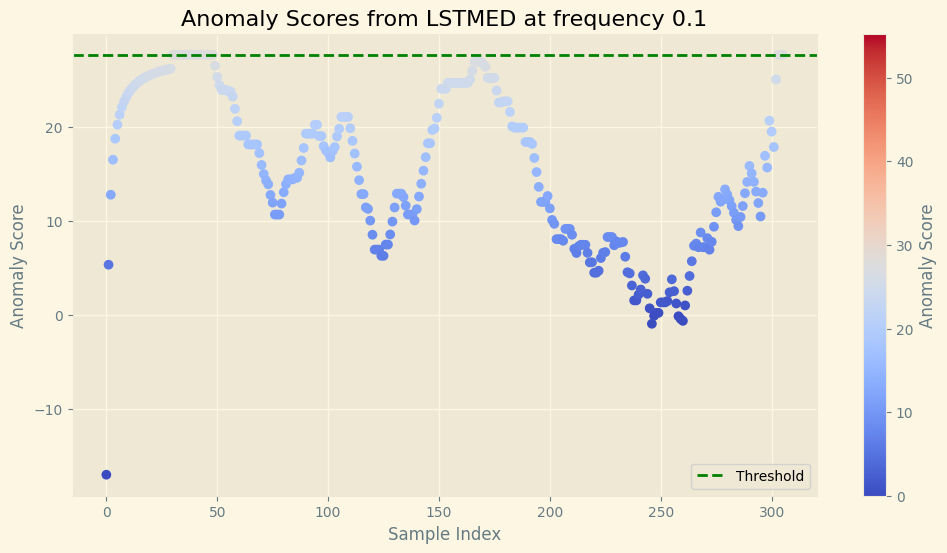

Number of anomalies detected: 0


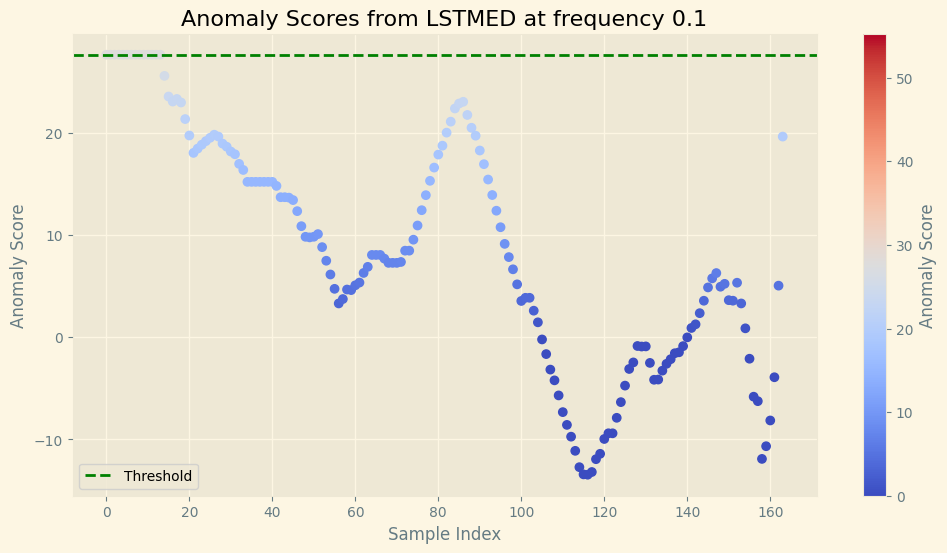

Number of anomalies detected: 0


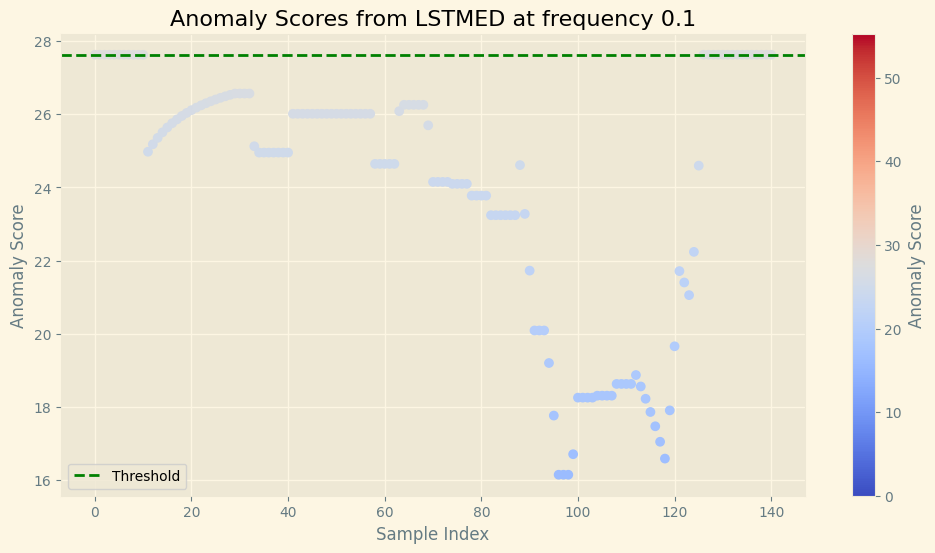

Number of anomalies detected: 0


In [17]:
anomalies_detected = plot_anomalies(anomaly_scores, freq, thresholds[2])
anomalies_detected1 = plot_anomalies(anomaly_scores1, freq, thresholds_1[2])
anomalies_detected5 = plot_anomalies(anomaly_scores5, freq, thresholds_5[2])

In [18]:
np.count_nonzero(y_collision), np.count_nonzero(y_collision_1), np.count_nonzero(y_collision_5)

(105, 35, 56)

In [19]:
compute_metrics(anomaly_scores, y_collision, thresholds[2])
print("############################################")
compute_metrics(anomaly_scores1, y_collision_1, thresholds_1[2])
print("############################################")
compute_metrics(anomaly_scores5, y_collision_5, thresholds_5[2])

ROC AUC Score: 0.5743
Detected anomaly class: 1
Threshold: 27.6310
F1 Score: 0.0000
Accuracy: 0.6569
Precision: 0.0000
Recall: 0.0000
              precision    recall  f1-score   support

           0       0.66      1.00      0.79       201
           1       0.00      0.00      0.00       105

    accuracy                           0.66       306
   macro avg       0.33      0.50      0.40       306
weighted avg       0.43      0.66      0.52       306

############################################
ROC AUC Score: 0.6575
Detected anomaly class: 1
Threshold: 27.6310
F1 Score: 0.0000
Accuracy: 0.7866
Precision: 0.0000
Recall: 0.0000
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       129
           1       0.00      0.00      0.00        35

    accuracy                           0.79       164
   macro avg       0.39      0.50      0.44       164
weighted avg       0.62      0.79      0.69       164

#################################

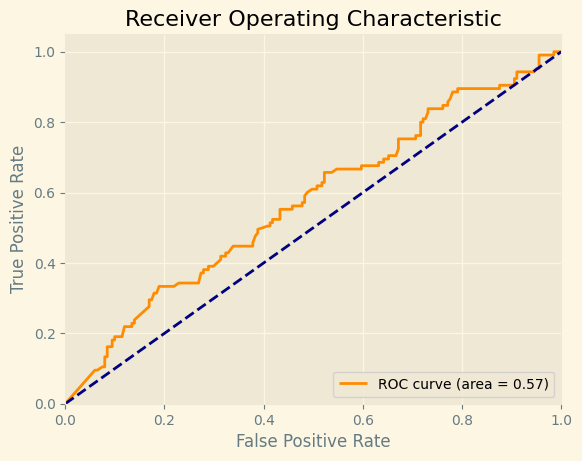

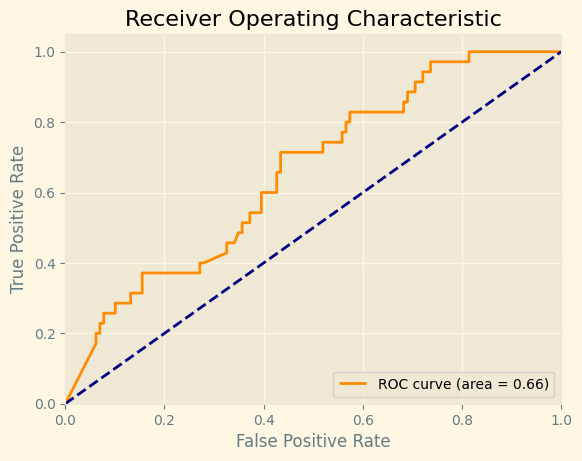

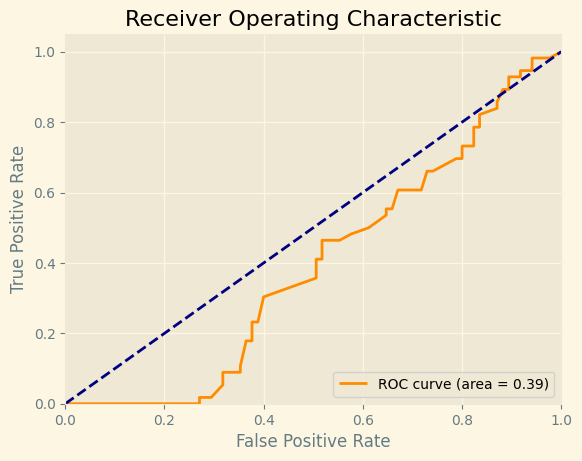

In [20]:
plot_roc_curve(y_collision, anomaly_scores)
plot_roc_curve(y_collision_1, anomaly_scores1)
plot_roc_curve(y_collision_5, anomaly_scores5)

## Map anomalies to original time series

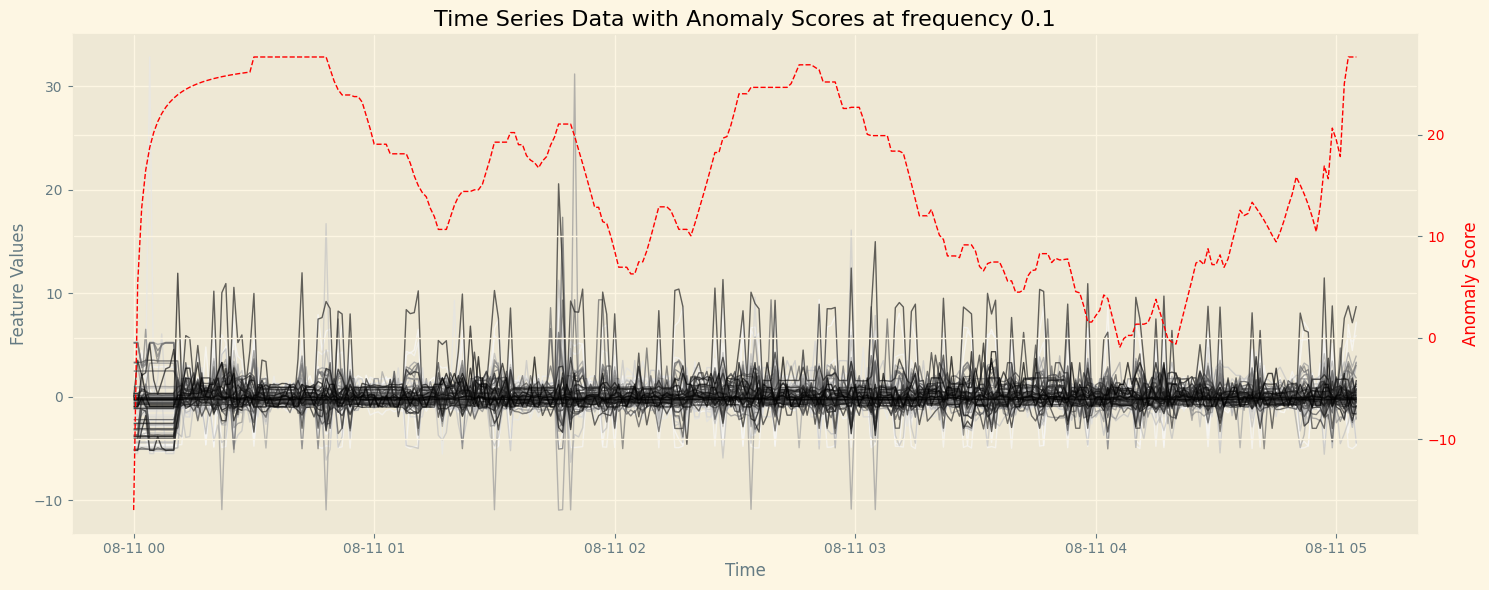

Top 0 Anomalies:
Empty DataFrame
Columns: [timestamp, anomaly_score, machine_nameKuka Robot_apparent_power-_Average power, machine_nameKuka Robot_apparent_power-_Variance, machine_nameKuka Robot_current-_Min, machine_nameKuka Robot_phase_angle-_Average power, machine_nameKuka Robot_phase_angle-_Variance, machine_nameKuka Robot_power-_ECDF Percentile_0, machine_nameKuka Robot_power-_Min, machine_nameKuka Robot_power_factor-_Histogram_9, machine_nameKuka Robot_reactive_power-_Absolute energy, machine_nameKuka Robot_reactive_power-_ECDF Percentile_0, machine_nameKuka Robot_reactive_power-_ECDF Percentile_1, machine_nameKuka Robot_reactive_power-_Mean absolute deviation, sensor_id1_AccX-_Histogram_5, sensor_id1_AccX-_Histogram_7, sensor_id1_AccY-_Interquartile range, sensor_id1_AccY-_Kurtosis, sensor_id1_AccZ-_Average power, sensor_id1_AngX-_Kurtosis, sensor_id1_AngX-_Max, sensor_id1_AngX-_Median absolute deviation, sensor_id1_AngY-_ECDF Percentile_1, sensor_id1_AngY-_Median, sensor_id1_An

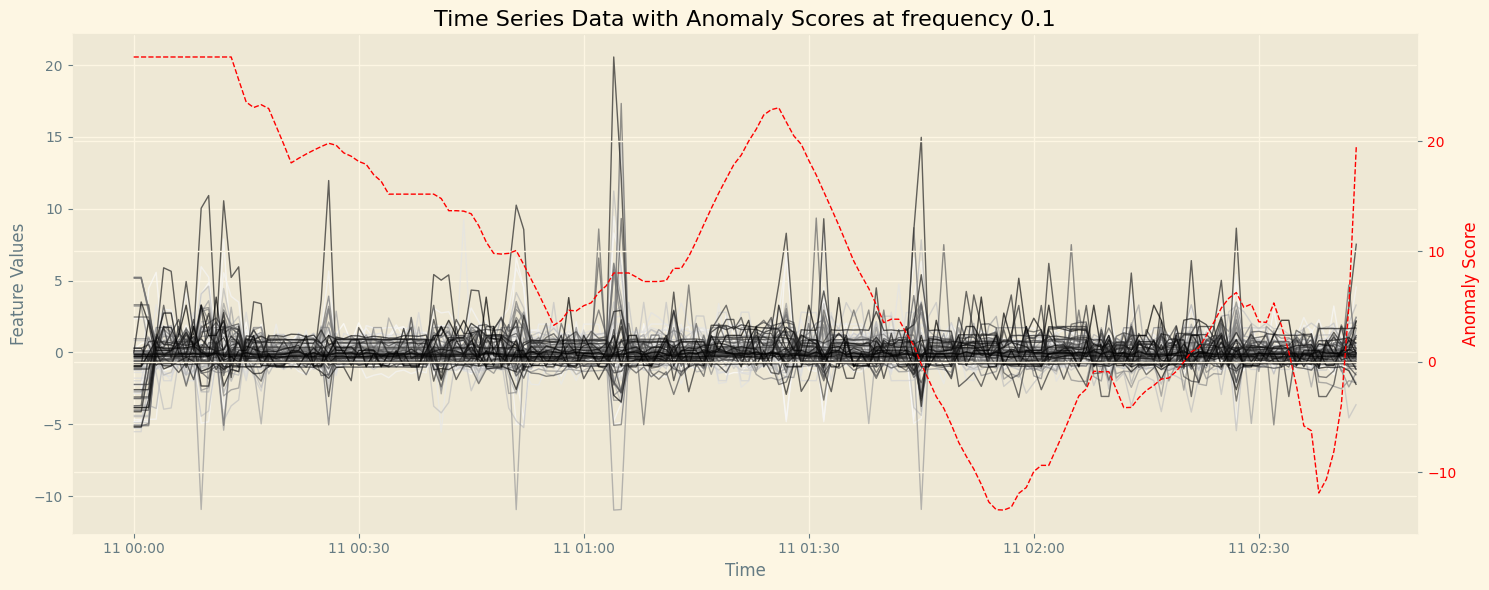

Top 0 Anomalies:
Empty DataFrame
Columns: [timestamp, anomaly_score, machine_nameKuka Robot_apparent_power-_Average power, machine_nameKuka Robot_apparent_power-_Variance, machine_nameKuka Robot_current-_Min, machine_nameKuka Robot_phase_angle-_Average power, machine_nameKuka Robot_phase_angle-_Variance, machine_nameKuka Robot_power-_ECDF Percentile_0, machine_nameKuka Robot_power-_Min, machine_nameKuka Robot_power_factor-_Histogram_9, machine_nameKuka Robot_reactive_power-_Absolute energy, machine_nameKuka Robot_reactive_power-_ECDF Percentile_0, machine_nameKuka Robot_reactive_power-_ECDF Percentile_1, machine_nameKuka Robot_reactive_power-_Mean absolute deviation, sensor_id1_AccX-_Histogram_5, sensor_id1_AccX-_Histogram_7, sensor_id1_AccY-_Interquartile range, sensor_id1_AccY-_Kurtosis, sensor_id1_AccZ-_Average power, sensor_id1_AngX-_Kurtosis, sensor_id1_AngX-_Max, sensor_id1_AngX-_Median absolute deviation, sensor_id1_AngY-_ECDF Percentile_1, sensor_id1_AngY-_Median, sensor_id1_An

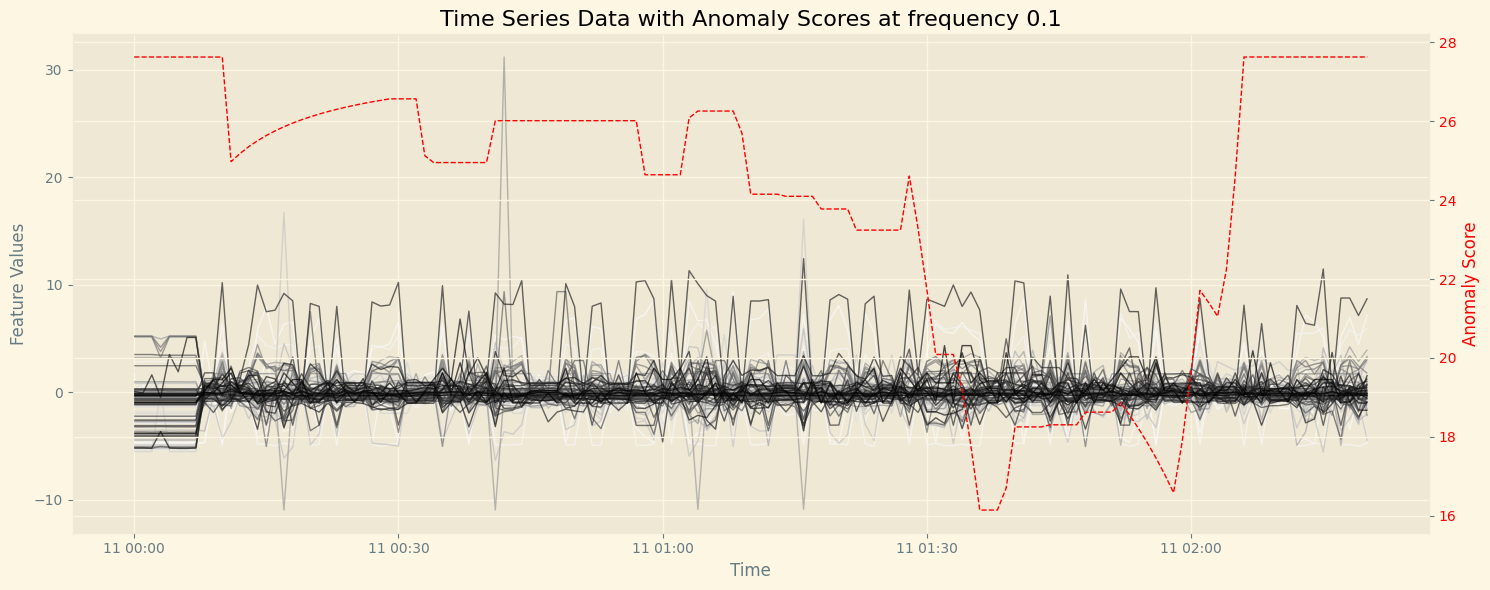

Top 0 Anomalies:
Empty DataFrame
Columns: [timestamp, anomaly_score, machine_nameKuka Robot_apparent_power-_Average power, machine_nameKuka Robot_apparent_power-_Variance, machine_nameKuka Robot_current-_Min, machine_nameKuka Robot_phase_angle-_Average power, machine_nameKuka Robot_phase_angle-_Variance, machine_nameKuka Robot_power-_ECDF Percentile_0, machine_nameKuka Robot_power-_Min, machine_nameKuka Robot_power_factor-_Histogram_9, machine_nameKuka Robot_reactive_power-_Absolute energy, machine_nameKuka Robot_reactive_power-_ECDF Percentile_0, machine_nameKuka Robot_reactive_power-_ECDF Percentile_1, machine_nameKuka Robot_reactive_power-_Mean absolute deviation, sensor_id1_AccX-_Histogram_5, sensor_id1_AccX-_Histogram_7, sensor_id1_AccY-_Interquartile range, sensor_id1_AccY-_Kurtosis, sensor_id1_AccZ-_Average power, sensor_id1_AngX-_Kurtosis, sensor_id1_AngX-_Max, sensor_id1_AngX-_Median absolute deviation, sensor_id1_AngY-_ECDF Percentile_1, sensor_id1_AngY-_Median, sensor_id1_An

In [21]:
plot_anomalies_over_time(X_test, anomaly_scores, anomalies_detected, freq)
plot_anomalies_over_time(X_test1, anomaly_scores1, anomalies_detected1, freq)
plot_anomalies_over_time(X_test5, anomaly_scores5, anomalies_detected5, freq)